# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

stock_name = "A"
df = pd.read_csv(
    "stocks/{}.csv".format(stock_name),
    index_col="Date",
    parse_dates=True,
    usecols=['Date', 'Close']
)

df = df.query("Date > '2004-01-01'")

df["Close"] = 100 * np.log(df['Close'] / df['Close'].shift(1)).dropna()

df = df.assign(
    sma9 = df.rolling(window=9).mean()["Close"],
    sma20 = df.rolling(window=20).mean()["Close"],
    std20 = df.rolling(window=20).std()["Close"]
).dropna()

train_size = int(0.67 * df.index.size)
scaler = StandardScaler()
data = scaler.fit_transform(df)

X = []
y = []


num_window = 52
idx = 0
idx_cols = range(df.columns.size)

for idx in range(len(data)-num_window):
    X.append(data[idx:idx+num_window,:])
    y.append(data[idx+num_window, idx_cols])
    
X = torch.tensor(np.array(X), requires_grad=True, dtype=torch.float64).view(-1, num_window, df.columns.size)
y = torch.tensor(np.array(y), requires_grad=True, dtype=torch.float64).view(-1, 1, len(idx_cols))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [2]:
class Data(Dataset):
    def __init__(self, x, y):
        super(Data, self).__init__()
        self.x = x 
        self.y = y
        self.len = x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.len
    
data_train = Data(X_train, y_train)
data_test = Data(X_test, y_test)

train_loader = DataLoader(data_train, batch_size=250)
test_loader = DataLoader(data_test, batch_size=250)

# Define Model

In [3]:
from torch import nn, optim, relu

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_features, dropout_probability=0.05):
        super(LSTMModel, self).__init__()
        self.h0 = torch.zeros(num_layers, X_train.size(1),  hidden_size, dtype=torch.float64)
        self.c0 = torch.zeros(num_layers, X_train.size(1),  hidden_size, dtype=torch.float64)
        self.out_features = out_features

        self.lstm = nn.LSTM(
            input_size=input_size
            , hidden_size=hidden_size
            , num_layers=num_layers
            , dtype=torch.float64
            , bias=True
            , dropout=dropout_probability
        )
        self.dropout = nn.Dropout(dropout_probability)
        self.middle_linear = nn.Linear(
            in_features=hidden_size,
            out_features=hidden_size,
            dtype=torch.float64
        )
        self.linear = nn.Linear(
            in_features=hidden_size
            , out_features=out_features
            , dtype=torch.float64
        )

        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
        nn.init.xavier_uniform_(self.linear.weight.data)

    def forward(self, activation):
        activation, (hn, cn) = self.lstm(activation, (self.h0.detach(), self.c0.detach()))
        activation = self.dropout(activation)
        activation = relu(self.middle_linear(activation))
        activation = self.linear(activation)
        activation = activation[:, -1, :].view(-1, 1, self.out_features)
        return activation#, (hn, cn)

# Train Model

In [4]:
input_size=X_train.size(-1)
hidden_size=128
num_layers=2
out_features=y_train.size(-1)
model = LSTMModel(input_size, hidden_size, num_layers, out_features)

learning_rate = 1e-2
num_epochs = 2000
criterion = nn.MSELoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.2
)
 

In [5]:
best_test_criterion = np.inf
best_model_path = "best_model.pt"

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_criterion = np.sqrt(criterion(y_pred, y_train))
        y_pred = model(X_test)
        test_criterion = np.sqrt(criterion(y_pred, y_test))
    print("Epoch %d: train criterion %.4f, test criterion %.4f" % (epoch, train_criterion, test_criterion))

    if test_criterion < best_test_criterion:
        best_test_criterion = test_criterion
        torch.save(model.state_dict(), best_model_path)

print(f"Best model saved to {best_model_path}")

Epoch 0: train criterion 1.0769, test criterion 0.7781
Epoch 10: train criterion 1.0347, test criterion 0.7715
Epoch 20: train criterion 0.9713, test criterion 0.7288
Epoch 30: train criterion 0.8808, test criterion 0.6617
Epoch 40: train criterion 0.8128, test criterion 0.6085
Epoch 50: train criterion 0.7679, test criterion 0.5728
Epoch 60: train criterion 0.7393, test criterion 0.5516
Epoch 70: train criterion 0.7237, test criterion 0.5410
Epoch 80: train criterion 0.7129, test criterion 0.5340
Epoch 90: train criterion 0.7041, test criterion 0.5283
Epoch 100: train criterion 0.6967, test criterion 0.5234
Epoch 110: train criterion 0.6904, test criterion 0.5194
Epoch 120: train criterion 0.6851, test criterion 0.5158
Epoch 130: train criterion 0.6805, test criterion 0.5127
Epoch 140: train criterion 0.6764, test criterion 0.5099
Epoch 150: train criterion 0.6726, test criterion 0.5072
Epoch 160: train criterion 0.6690, test criterion 0.5045
Epoch 170: train criterion 0.6657, test cr

# Load the best model
If you prefer to skip the training process, you can jump to this cell.

In [17]:
best_model_path = "best_model.pt"
model.load_state_dict(torch.load(best_model_path))
model.eval()

LSTMModel(
  (lstm): LSTM(4, 128, num_layers=2, dropout=0.05)
  (dropout): Dropout(p=0.05, inplace=False)
  (middle_linear): Linear(in_features=128, out_features=128, bias=True)
  (linear): Linear(in_features=128, out_features=4, bias=True)
)

# Visualize Predictions Solution

In [18]:
import matplotlib.pyplot as plt 
y_pred_v = scaler.inverse_transform(model(X_test).detach().view(-1, 4))[:, 0]
y_test_v = scaler.inverse_transform(y_test.detach().view(-1, 4))[:, 0]

In [23]:
df_plot = pd.DataFrame(
    np.array(
        [
            np.exp(y_test_v / 100).cumprod()
            , np.exp(y_pred_v / 100)
        ]
    ).T, columns=["actual_price", "pred_log_returns"]
)

<Axes: >

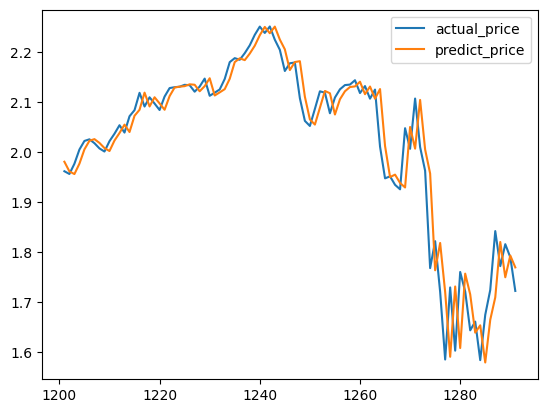

In [24]:
df_plot["pred_log_returns"] = df_plot.pred_log_returns.shift(-1)
df_plot["predict_price"] = (df_plot["actual_price"] * df_plot["pred_log_returns"]).shift(1)
df_plot[df_plot.index > 1200][["actual_price", "predict_price"]].dropna().plot()

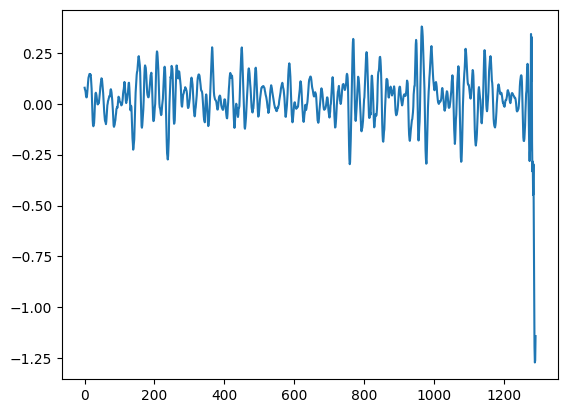

In [10]:
import matplotlib.pyplot as plt 
plt.plot(y_pred_v)

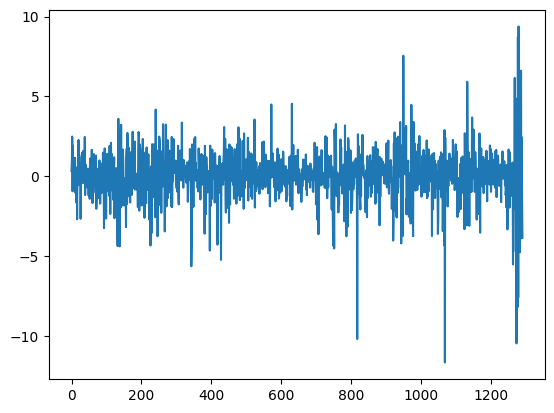

In [11]:
plt.plot(y_test_v)

In [12]:
print(y_test_v.mean(), y_pred_v.mean())
print(y_test_v.mean() - y_pred_v.mean())

0.04207175267011937 0.02540724622072746
0.016664506449391908


In [13]:
print(y_test_v.std(), y_pred_v.std())
print(y_test_v.std() - y_pred_v.std())

1.6216802142542446 0.12896046387149496
1.4927197503827496


In [14]:

# y_pred_values = scaler.inverse_transform(model(X_test).view(-1, len(idx_cols)).detach().numpy())
# y_test_values = scaler.inverse_transform(y_test.view(-1, len(idx_cols)).detach().numpy())

In [15]:
# plt.plot(y_pred_values[-200:, 3], label="model")
# plt.plot(y_test_values[-200:, 3], label="stock")
# plt.legend()

In [16]:
# y_pred = model(X_test)
# np.sqrt(criterion(y_pred.detach(), y_test.detach()))